### import Libraries

In [1]:
import math
from skimage.feature import blob_dog
from skimage.color import rgb2gray
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches)

# Task 1 : Detecting Interest Points

### Rescaling Images

In [2]:
img = cv2.imread("im1red.png")
scale_percent = 10 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)

img_org = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

cv2.imwrite( "im1red_downscaled.png", img_org)

True

In [3]:
img = cv2.imread("im2red.png")
scale_percent = 10 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)

img_org = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

cv2.imwrite( "im2red_downscaled.png", img_org)

True

### Difference of Gaussian

In [4]:
#image2 = cv2.imread("81329194_615711955638407_7894042335476973568_n.png")
#image1 = cv2.imread("82110016_465906421025540_5017787395446145024_n.png")

image1 = cv2.imread("im1red_downscaled.png")
image2 = cv2.imread("im2red_downscaled.png")

#image1 = cv2.imread("im1red.png")
#image2 = cv2.imread("im2red.png")

image_gray1 = rgb2gray(image1)
image_gray2 = rgb2gray(image2)

DoG1 = blob_dog(image_gray1, max_sigma=3,  threshold=0.1)
DoG2 = blob_dog(image_gray2, max_sigma=3,  threshold=0.1)
# radii 3. column 
DoG1[:, 2] = DoG1[:, 2] * np.sqrt(2)
DoG2[:, 2] = DoG2[:, 2] * np.sqrt(2)


DoG_list = [DoG1, DoG2]

### plot DoG on original image 

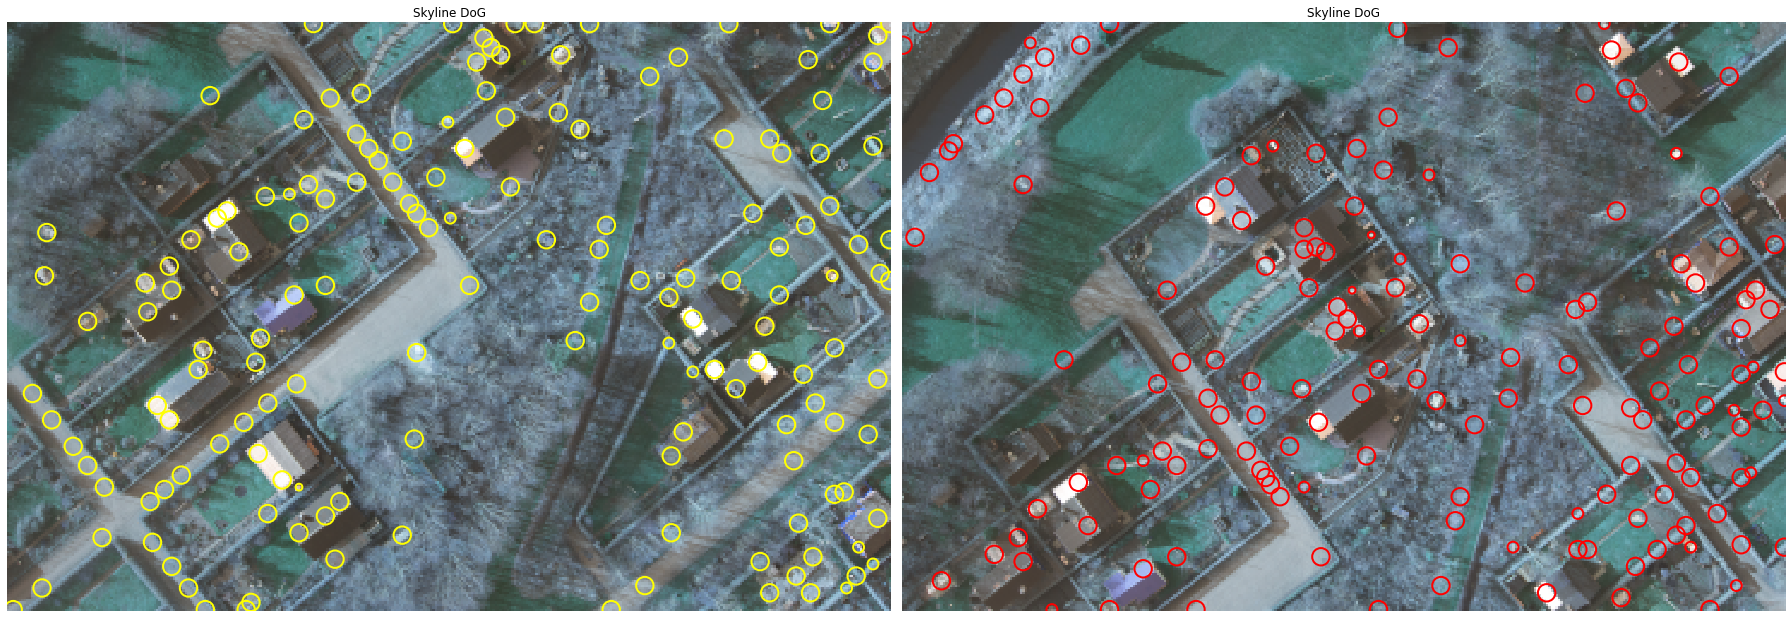

In [5]:
color = ['yellow', "red"]
title= ['Skyline DoG',"Skyline DoG"]  # , 'diku','blob image'
seq = zip(DoG_list, color, title)

fig, axe = plt.subplots(1,2,figsize=(25, 15))
ax = axe.ravel()

for i, (DoG, color, title) in enumerate(seq):
    ax[i].set_title(title)
    ax[0].imshow(image1)
    ax[1].imshow(image2)
    for blob in DoG:
        y, x, r = blob       
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax[i].add_patch(c)
    ax[i].set_axis_off()

plt.tight_layout()
plt.savefig("im1red - im2red.png")
plt.show()

# Task 2 : Feature Matching

### Extract X and Y coordinates for keypoints

In [6]:
x = DoG1[:,0]
y = DoG1[:,1]

x2 = DoG2[:,0]
y2 = DoG2[:,1]

### Collection of functions for pre-processing and creation of descriptors

In [7]:
def axis_remover3(x,y,image):
    zerox = np.where(x == 0)
    new_x , new_y = np.delete(x,zerox),np.delete(y,zerox)   
    zeroy = np.where(new_y == 0)
    new_x , new_y = np.delete(new_x,zeroy),np.delete(new_y,zeroy)  
    
    maxx = np.where(new_x == image.shape[0]-1)
    new_x , new_y = np.delete(new_x,maxx),np.delete(new_y,maxx)   
    maxy = np.where(new_y == image.shape[1]-1)
    new_x , new_y = np.delete(new_x,maxy),np.delete(new_y,maxy)  
    return new_x, new_y

def axis_remover5(x,y,image):
    
    onex = np.where(x == 1)
    new_x , new_y = np.delete(x,onex),np.delete(y,onex)   
    oney = np.where(new_y == 1)
    new_x , new_y = np.delete(new_x,oney),np.delete(new_y,oney)      
    
    maxx2 = np.where(new_x == image.shape[0]-2)
    new_x , new_y = np.delete(new_x,maxx2),np.delete(new_y,maxx2)   
    maxy2 = np.where(new_y == image.shape[1]-2)
    new_x , new_y = np.delete(new_x,maxy2),np.delete(new_y,maxy2)      
    return new_x, new_y

def patch_descriptor(new_x,new_y,image):
    patch = np.zeros([len(new_x),3,3])
    patch5 = np.zeros([len(new_x),5,5]) 
    for j in range(len(new_x)):
        center = new_x[j],new_y[j]
        patch[j] = image[center[0]-1:center[0]+2,center[1]-1:center[1]+2]
        mean= np.mean(patch[j])
        std = np.std(patch[j])
        patch[j] = patch[j]-mean
        patch[j] = patch[j]/std
        
        patch5[j] = image[center[0]-2:center[0]+3,center[1]-2:center[1]+3]        
        mean= np.mean(patch5[j])
        std = np.std(patch5[j])
        patch5[j] = patch5[j]-mean
        patch5[j] = patch5[j]/std
        
        
    return patch,patch5

### Generating new x and y coordinates based on the pre-processed dataset

In [8]:
new_x, new_y = axis_remover3(x,y,image_gray1)
new_x = np.array(new_x).astype(int)
new_y = np.array(new_y).astype(int)

new_x2, new_y2 = axis_remover3(x2,y2,image_gray2)
new_x2 = np.array(new_x2).astype(int)
new_y2 = np.array(new_y2).astype(int)

N5_x, N5_y = axis_remover5(new_x,new_y,image_gray1)
N5_x =np.array(N5_x).astype(int)
N5_y =np.array(N5_y).astype(int)

N5_x2, N5_y2 = axis_remover5(new_x2,new_y2,image_gray2)
N5_x2 =np.array(N5_x2).astype(int)
N5_y2 =np.array(N5_y2).astype(int)

N3_patch = patch_descriptor(new_x,new_y,image_gray1)[0]
N3_patch2 = patch_descriptor(new_x2, new_y2, image_gray2)[0]
N5_patch = patch_descriptor(N5_x,N5_y,image_gray1)[1]
N5_patch2 = patch_descriptor(N5_x2, N5_y2, image_gray2)[1]



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


### Displaying proof of normal distribution and center values

In [9]:
patch_center = new_x[0],new_y[0]

#patch_image = image_gray1[patch_center[0]-1:patch_center[0]+2, patch_center[1]-1:patch_center[1]+2]
patch_image = N3_patch[0]

print('This is the normalized center ' + str(patch_center))
print('std: ' + str(np.std(patch_image)))
print('mean: ' + str(np.mean(patch_image)))
patch_image

This is the normalized center (241, 101)
std: 1.0
mean: 3.3430048852601935e-15


array([[ 0.32842625,  0.05301921, -1.17075453],
       [ 0.77866864, -1.16484915,  1.03557324],
       [-1.6276886 ,  1.25222132,  0.51538361]])

### Collection of functions for calculating similarities and matching 

In [10]:
def L2_Norm(patch1,patch2):
    squared = 0
    for i in range(len(patch1)):
        for j in range(len(patch1)):
            squared += (patch1[i,j]-patch2[i,j])**2
            L2_norm = np.sqrt(squared)
    return L2_norm

def patch_squared(patch1,patch2): # Function for "the Sum of squared descriptor difference "
    squared = 0
    for i in range(len(patch1)):
        for j in range(len(patch1)):
            squared += (patch1[i,j]-patch2[i,j])**2
    return squared

def matcher(patch_list_A,patch_list_B):
    # Take a patch from A and compare them with every patch in B 
    # Counter for counting what index from patch1 i use. used to refer back to the OG image.
    counter = -1
    patch_match = np.zeros([len(patch_list_A),2])
    min_match = np.zeros([len(patch_list_A)])
    for i in range(len(patch_list_A)):
        match_temp = []
        counter +=1
        if np.isnan(patch_list_A[i,0,0]):# If the matrix has NaN skip it and start loop again.
            continue
        for j in range(len(patch_list_B)):
            if np.isnan(patch_list_B[j,0,0]):
                continue    
            match_temp.append(patch_squared(patch_list_A[i],patch_list_B[j])) # using the squared differences algorithm        
        min_match[i] = np.min(match_temp)
        min_match_index = np.argmin(match_temp)
        patch_match[i] = counter,min_match_index 
    return(patch_match,min_match) # returning the index for both patch1 and patch2, and the minimum value from squared diff

### Calling functions and storing results in variables that can be used for later

In [11]:
patch_index, min_match = matcher(N3_patch,N3_patch2)

patch_index5, min_match5 = matcher(N5_patch, N5_patch2)

### Functions for identifying smallest k array of number and their corresponding matches 

In [12]:
def get_indices_of_k_smallest(arr, k):
    idx = np.argpartition(arr.ravel(), k)
    return tuple(np.array(np.unravel_index(idx, arr.shape))[:, range(min(k, 0), max(k, 0))])
# Above function is NOT our code
# https://stackoverflow.com/questions/34226400/find-the-index-of-the-k-smallest-values-of-a-numpy-array

def best_match(patch_match,smallest_array_index):
    best_match = np.zeros([len(smallest_array_index),2])
    for i in smallest_array_index:
        best_match =patch_match[i,0],patch_match[i,1]
    
    return best_match    

def zero_remover(array):
    array = array[~np.all(array == 0, axis=1)]
    return array

### Calling functions for creation of best matches for both 3 and 5 patch 

In [13]:
#Retrieve the indices of the smallest points
smallest_comparison = get_indices_of_k_smallest(min_match,20)
smallest_comparison5 = get_indices_of_k_smallest(min_match5, 20)

#Match patches 
match_patch = best_match(patch_index,smallest_comparison)
match_patch = np.transpose(match_patch)
match_patch = zero_remover(match_patch)

match_patch5 = best_match(patch_index5, smallest_comparison5)
match_patch5 = np.transpose(match_patch5)
match_patch5 = zero_remover(match_patch5)
#remove zeros if any


### creating the correct keypoint matrices for matches 

In [14]:
patch_3xy = np.transpose(np.array([new_x, new_y]))

patch_3xy2 = np.transpose(np.array([new_x2, new_y2]))

patch_5xy = np.transpose(np.array([N5_x, N5_y]))

patch_5xy2 = np.transpose(np.array([N5_x2, N5_y2]))

### Plot matches against each other

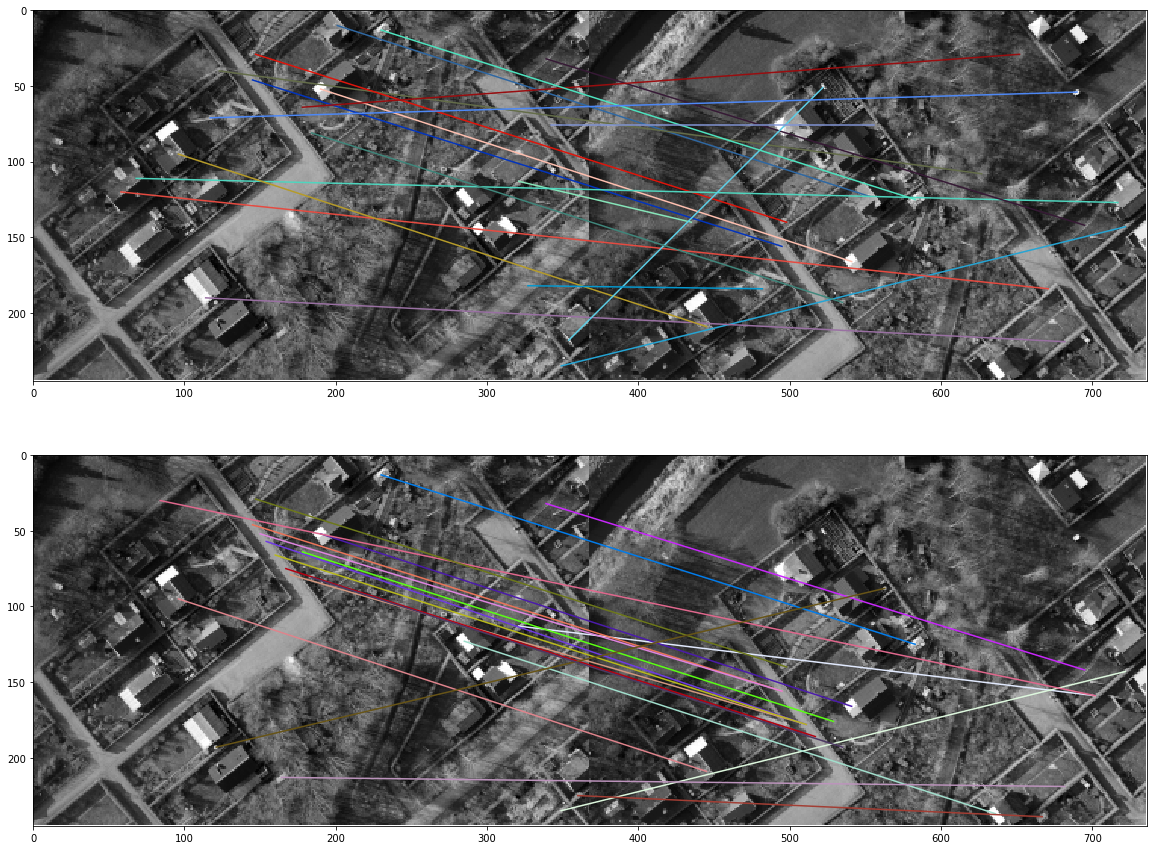

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(25,15))

plot_matches(ax[0], image_gray1, image_gray2,  patch_3xy ,patch_3xy2, match_patch.astype(int), only_matches=True)
plot_matches(ax[1], image_gray1, image_gray2, patch_5xy ,patch_5xy2, match_patch5.astype(int), only_matches=True)
plt.show()

## Library implementation of Feature Matching


In [16]:
descriptor_extractor = ORB(n_keypoints=100)

In [17]:
descriptor_extractor.detect_and_extract(image_gray1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

In [18]:
descriptor_extractor.detect_and_extract(image_gray2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

In [19]:
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

Text(0.5, 1.0, 'Original Image vs. Transformed Image')

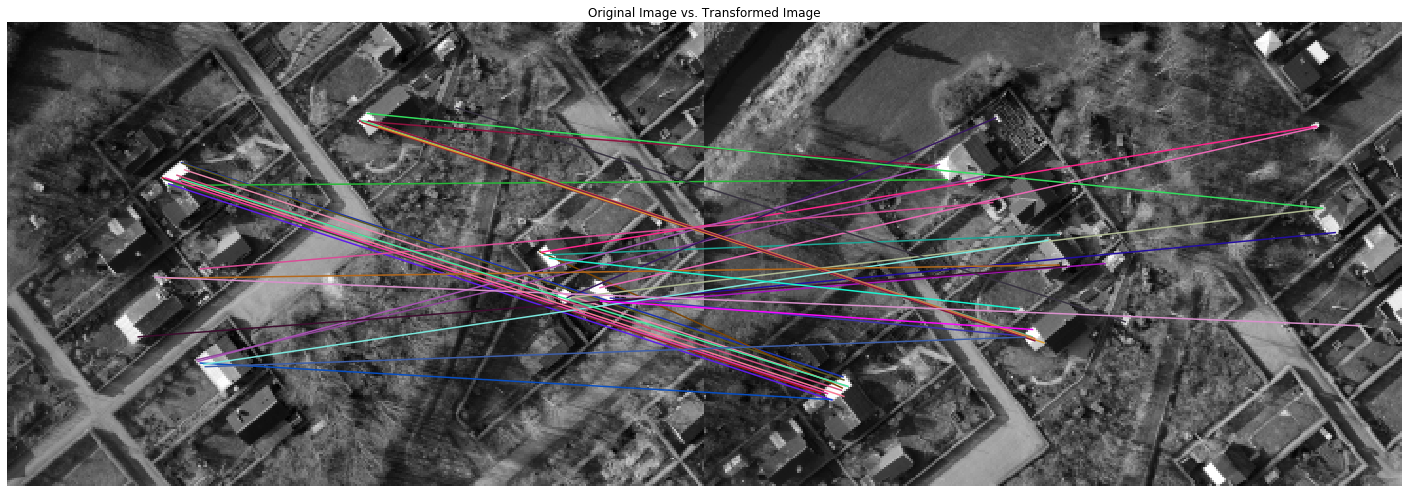

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,15))

plt.gray()

plot_matches(ax, image_gray1, image_gray2, keypoints1, keypoints2, matches12, only_matches=True)
ax.axis('off')
ax.set_title("Original Image vs. Transformed Image")

### Task 3: Image Stitching

#### Homography

In [21]:
def homography(img1_match_coor,img2_match_coor):
    xy=img1_match_coor
    xy_dot = img2_match_coor
    M = np.array([[xy[0,0], xy[0,1], 1, 0, 0, 0, -1*(xy[0,0]*xy_dot[0,0]), -1*(xy[0,1]*xy_dot[0,0])],
                  [0, 0, 0, xy[0,0], xy[0,1], 1, -1*(xy[0,0]*xy_dot[0,1]), -1*(xy[0,1]*xy_dot[0,1])],
                  [xy[1,0], xy[1,1], 1, 0, 0, 0, -1*(xy[1,0]*xy_dot[1,0]), -1*(xy[1,1]*xy_dot[1,0])],
                  [0, 0, 0, xy[1,0], xy[1,1], 1, -1*(xy[1,0]*xy_dot[1,1]), -1*(xy[1,1]*xy_dot[1,1])],
                  [xy[2,0], xy[2,1], 1, 0, 0, 0, -1*(xy[2,0]*xy_dot[2,0]), -1*(xy[2,1]*xy_dot[2,0])],
                  [0, 0, 0, xy[2,0], xy[2,1], 1, -1*(xy[2,0]*xy_dot[2,1]), -1*(xy[2,1]*xy_dot[2,1])],
                  [xy[3,0], xy[3,1], 1, 0, 0, 0, -1*(xy[3,0]*xy_dot[3,0]), -1*(xy[3,1]*xy_dot[3,0])],
                  [0, 0, 0, xy[3,0], xy[3,1], 1, -1*(xy[3,0]*xy_dot[3,1]), -1*(xy[3,1]*xy_dot[3,1])]])

    h = np.array([[xy_dot[0,0]],[xy_dot[0,1]],[xy_dot[1,0]],[xy_dot[1,1]]
                  ,[xy_dot[2,0]],[xy_dot[2,1]],[xy_dot[3,0]],[xy_dot[3,1]]])

    test = np.dot(np.linalg.inv(M), h)
    H = np.array([[test[0,0], test[1,0], test[2,0]],
                  [test[3,0], test[4,0], test[5,0]],
                  [test[6,0], test[7,0], 1]])
    return H

In [22]:
img1_match_coor =np.zeros([len(match_patch),2])
img2_match_coor =np.zeros([len(match_patch),2])
match_patch = match_patch.astype(int)
for i in range(len(match_patch)):
    img1_match_coor[i] = ([new_x[match_patch[i][0]],new_y[match_patch[i][0]]])
    img2_match_coor[i] = ([new_x2[match_patch[i][1]],new_y2[match_patch[i][1]]])

In [23]:
homography_test= homography(img1_match_coor,img2_match_coor)

In [24]:
print( 'Homography estimate: '+ '\n' + str(homography_test))

Homography estimate: 
[[ 4.43967828e-01 -7.90888013e-01  1.15494495e+02]
 [ 6.90597519e-01 -1.59311751e+00  2.54600493e+02]
 [ 4.10952949e-03 -6.75844512e-03  1.00000000e+00]]


#### Library implementation of Stitching

##### Loading Images

In [25]:
image1 = cv2.imread("im1red_downscaled.png")
image2 = cv2.imread("im2red_downscaled.png")

##### Creating container list for images

In [26]:
images = [image1, image2]

##### Initiating Stitcher

In [27]:
stitcher = cv2.Stitcher_create()
status, stitched = stitcher.stitch(images)

##### Checking whether stitching operation is succesful

In [28]:
if status == 0:
    print("Code 0. Image stitched succesfully")
else:
    print("Something went wrong")

Code 0. Image stitched succesfully


##### Writing stitched image to disk

In [29]:
cv2.imwrite("output.png",stitched)

True

##### Showing Stitched Image

In [ ]:
cv2.imshow("Stitched", stitched)
cv2.waitKey(0)